# 1. Set ups and Prep work

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import PIL.Image as Image
import cv2
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import os
from google.colab import drive
drive.mount('/content/drive')

base_path = "/content/drive/My Drive/CS7643-LaneDetection/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


1.1 Load original dataset to visualize

Shape of training images:  (12764, 80, 160, 3)
Shape of label images:  (12764, 80, 160, 1)



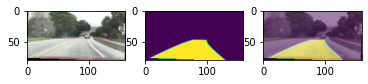

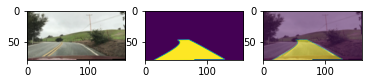

<Figure size 432x288 with 0 Axes>

In [2]:
train_images = pickle.load(open(base_path + "full_CNN_train.p", "rb" ))
# Load image labels
labels = pickle.load(open(base_path + "full_CNN_labels.p", "rb" ))

# Make into arrays as the neural network wants these
train_images = np.array(train_images)
labels = np.array(labels)

# Dataset Analysis
print("Shape of training images: ", train_images.shape)
print("Shape of label images: ", labels.shape)
print()

for i in range(2):
    idx = np.random.randint(0, train_images.shape[0])
    img = train_images[idx]
    label = np.squeeze(labels[idx])
    
    plt.subplot(1,3,1)
    plt.imshow(img)

    plt.subplot(1,3,2)
    plt.imshow(label)

    plt.subplot(1,3,3)

    plt.imshow(img)
    plt.imshow(label, alpha=0.5)
        
    plt.figure()

plt.show()

1.2 Resize the images for model input

100%|██████████| 12764/12764 [00:02<00:00, 5536.91it/s]


Shape of training images:  (12764, 80, 160, 3)
Shape of label images:  (12764, 224, 224, 1)



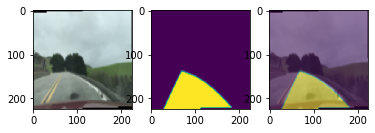

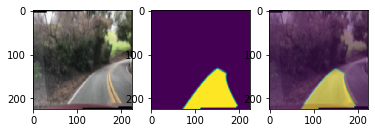

<Figure size 432x288 with 0 Axes>

In [3]:
new_size = 224
data =  np.stack([np.asarray(Image.fromarray(current_data).resize((new_size, new_size), Image.NEAREST)) 
                        for current_data in tqdm(train_images)])



labels = np.stack([np.asarray(Image.fromarray(np.concatenate([current_data,current_data,current_data],axis=2)).resize((new_size, new_size), Image.NEAREST)) 
                         for current_data in tqdm(labels)])[...,:1]

print("Shape of training images: ", train_images.shape)
print("Shape of label images: ", labels.shape)
print()
for i in range(2):
    idx = np.random.randint(0, train_images.shape[0])
    current_data = data[idx]
    current_label = np.squeeze(labels[idx])
    
    plt.subplot(1,3,1)
    plt.imshow(current_data)

    plt.subplot(1,3,2)
    plt.imshow(current_label)

    plt.subplot(1,3,3)

    plt.imshow(current_data)
    plt.imshow(current_label, alpha=0.5)
        
    plt.figure()

plt.show()

1.3 Split the training, validation, and testing dataset

In [4]:
# split the training, validation, and test dataset
train_test_ratio = 0.8
train_val_ratio = 0.8
train_imgs, test_imgs, train_labels, test_labels = train_test_split(data, labels, train_size=train_test_ratio)
train_imgs, val_imgs, train_labels, val_labels = train_test_split(train_imgs, train_labels, train_size=train_val_ratio)
train_size = train_imgs.shape[0]
val_size = val_imgs.shape[0]
test_size = test_imgs.shape[0]
print("Training dataset size: ", train_size)
print("Validation dataset size: ", val_size)
print("Testing dataset size: ", test_size)

Training dataset size:  8168
Validation dataset size:  2043
Testing dataset size:  2553


1.4 Split the dataset into batch size

In [0]:
def sample_dataset_minibatch(X, y, batch_size):
    split_size = len(X)

    mask = np.random.choice(X.shape[0], batch_size)
    X, y = X[mask], y[mask]
    X = np.transpose(X,(0,3,1,2))
    y = np.transpose(y,(0,3,1,2))

    return X, y

# 2. Model Implementation

In [0]:
class UNet(nn.Module):
    def contracting_block(self, in_channels, out_channels, kernel_size=3):
        block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=out_channels, padding=(1,1)),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(out_channels),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=out_channels, out_channels=out_channels,padding=(1,1)),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(out_channels),
                )
        return block
    
    def expansive_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
            block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel, padding=(1,1)),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel, padding=(1,1)),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.ConvTranspose2d(in_channels=mid_channel, out_channels=out_channels, kernel_size=3, stride=2, padding=1, output_padding=1)
                    )
            return  block
    
    def final_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
            block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel, padding=(1,1)),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel, padding=(1,1)),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=out_channels, padding=1),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(out_channels),
                    )
            return  block
    
    def bottle(self):
        block = torch.nn.Sequential(
                            torch.nn.Conv2d(kernel_size=3, in_channels=256, out_channels=512, padding=(1,1)),
                            torch.nn.ReLU(),
                            torch.nn.BatchNorm2d(512),
                            torch.nn.Conv2d(kernel_size=3, in_channels=512, out_channels=512, padding=(1,1)),
                            torch.nn.ReLU(),
                            torch.nn.BatchNorm2d(512),
                            torch.nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
                            )
        return block
    
    def __init__(self, in_channel, out_channel):
        super(UNet, self).__init__()
        #Encode
        self.conv_encode1 = self.contracting_block(in_channels=in_channel, out_channels=64)
        self.conv_maxpool1 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode2 = self.contracting_block(64, 128)
        self.conv_maxpool2 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode3 = self.contracting_block(128, 256)
        self.conv_maxpool3 = torch.nn.MaxPool2d(kernel_size=2)
        # Bottleneck
        self.bottleneck = self.bottle()
        # Decode
        self.conv_decode3 = self.expansive_block(512, 256, 128)
        self.conv_decode2 = self.expansive_block(256, 128, 64)
        self.final_layer = self.final_block(128, 64, out_channel)
        
    def crop_and_concat(self, upsampled, bypass, crop=False):
        if crop:
            c = (bypass.size()[2] - upsampled.size()[2]) // 2
            bypass = F.pad(bypass, (-c, -c, -c, -c))
        return torch.cat((upsampled, bypass), 1)
    
    def forward(self, x):
        # Encode
        # print("x size: ", x.size())
        encode_block1 = self.conv_encode1(x)
        # print("encode block 1 size: ", encode_block1.size())
        encode_pool1 = self.conv_maxpool1(encode_block1)
        # print("encode block 1 pool size: ", encode_pool1.size())

        encode_block2 = self.conv_encode2(encode_pool1)
        # print("encode block 2 size: ", encode_block2.size())

        encode_pool2 = self.conv_maxpool2(encode_block2)
        # print("encode block 2 pool size: ", encode_pool2.size())

        encode_block3 = self.conv_encode3(encode_pool2)
        encode_pool3 = self.conv_maxpool3(encode_block3)
        # print("encode block 3 size: ", encode_block3.size())
        # print("encode block 3 pool size: ", encode_pool3.size())


        # Bottleneck
        bottleneck1 = self.bottleneck(encode_pool3)
        # print("bottleneck size: ", bottleneck1.size())
        # Decode
        decode_block3 = self.crop_and_concat(bottleneck1, encode_block3, crop=True)
        # print("decode block 3 size: ", decode_block3.size())
        cat_layer2 = self.conv_decode3(decode_block3)
        # print("cat layer 2 size: ", cat_layer2.size())
        decode_block2 = self.crop_and_concat(cat_layer2, encode_block2, crop=True)
        # print("decode block 2 size: ", decode_block2.size())
        cat_layer1 = self.conv_decode2(decode_block2)
        # print("cat layer 1 size: ", cat_layer1.size())
        decode_block1 = self.crop_and_concat(cat_layer1, encode_block1, crop=True)
        # print("last layer before final layer: ", decode_block1.size())
        final_layer = self.final_layer(decode_block1)
        return  final_layer


# Dice loss
class DiceLoss(torch.nn.Module):
    def init(self):
        super(diceLoss, self).init()
    def forward(self,pred, target):
       smooth = 1.
       iflat = pred.contiguous().view(-1)
       tflat = target.contiguous().view(-1)
       intersection = (iflat * tflat).sum()
       A_sum = torch.sum(iflat * iflat)
       B_sum = torch.sum(tflat * tflat)
       return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth) )

In [8]:
# Training Process
in_channel = 3
out_channel = 1

batch_size = 16         # batch size
batch_iterations = int(train_size / batch_size + 0.5)
num_epochs = 50             # number of training epochs
learning_rate = 5e-3
momentum = 0.99
lr_decay_step_size = 500
lr_decay = 0.995

print_every = 10          # determines window for printing average loss
save_every = 500            #determine window for saving state point of model

model_path = base_path + "/UNet_50epochs_16batch_5e-3lr_0.995lrd.pt"
training_path = base_path + "/training_process2.txt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(in_channel, out_channel)
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))

# Move models to GPU if CUDA is available. 
model.to(device)

# Define the loss function. 
criterion = DiceLoss()

optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=0.99)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_decay_step_size, gamma=lr_decay)

# training_file = open(training_path, 'w')

iterations_per_epoch = max(train_size // batch_size, 1)
num_iterations = num_epochs * iterations_per_epoch

for i in range(num_iterations):
    X,y = sample_dataset_minibatch(train_imgs, train_labels, batch_size)

    model.zero_grad()

    X, y = torch.from_numpy(X).float().to(device), torch.from_numpy(y).long().to(device)

    outputs = model(X)
    # print("outputs size: ", outputs.size())
    # print("y size: ", y.size())
    # outputs = outputs.view(outputs.size(0), -1)
    # y = y.view(y.size()[0], -1)

    train_loss = criterion(outputs, y)
    # print(train_loss)
    # print(tag_score, post_type)
    # print("loss of {} type discourse: {}".format(tag, loss))
    train_loss.backward()
    
    # Update the parameters in the optimizer.
    optimizer.step()
    
    if i % print_every == 0:
        with torch.no_grad():
            # print("start testing...")
            X, y = sample_dataset_minibatch(val_imgs, val_labels, batch_size)
            X, y = torch.from_numpy(X).float().to(device), torch.from_numpy(y).long().to(device)
            # print("X size: ", X.size())

            outputs = model(X)

            validation_loss = criterion(outputs, y)

            stats = 'Iterations [%d/%d], Train Loss: %f, Validation Loss: %f'  \
                    % (i, num_iterations, train_loss, validation_loss)

            print(stats)

    if i % save_every == 0:
        torch.save(model.state_dict(), model_path)
# Save the model
torch.save(model.state_dict(), model_path)

Iterations [0/25500], Train Loss: 1.001415, Validation Loss: 1.000758
Iterations [10/25500], Train Loss: 0.998528, Validation Loss: 0.997252
Iterations [20/25500], Train Loss: 0.992480, Validation Loss: 0.992196
Iterations [30/25500], Train Loss: 0.991629, Validation Loss: 0.990416
Iterations [40/25500], Train Loss: 0.990094, Validation Loss: 0.990619
Iterations [50/25500], Train Loss: 0.989266, Validation Loss: 0.989227
Iterations [60/25500], Train Loss: 0.988408, Validation Loss: 0.988803
Iterations [70/25500], Train Loss: 0.987195, Validation Loss: 0.988527
Iterations [80/25500], Train Loss: 0.987635, Validation Loss: 0.987067
Iterations [90/25500], Train Loss: 0.987023, Validation Loss: 0.986028
Iterations [100/25500], Train Loss: 0.986044, Validation Loss: 0.983820
Iterations [110/25500], Train Loss: 0.985096, Validation Loss: 0.984802
Iterations [120/25500], Train Loss: 0.982886, Validation Loss: 0.984128
Iterations [130/25500], Train Loss: 0.983011, Validation Loss: 0.982048
Ite

#3. Model Evaluation

3.1 Test dataset evaluation - run model on test dataset, see the loss, and visualize

Loss:  0.0058106184005737305

   Input Images,     Labels,   Model Outputs


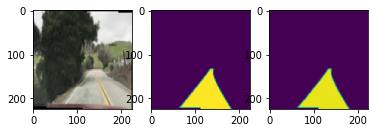

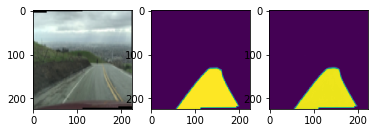

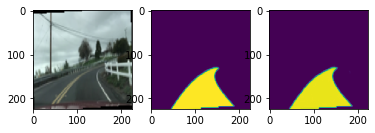

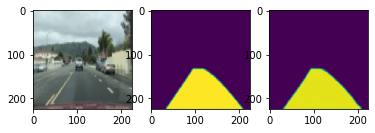

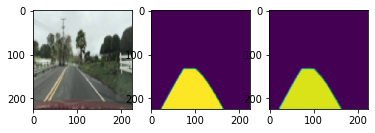

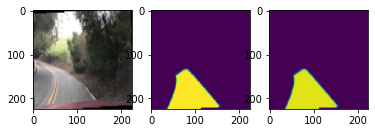

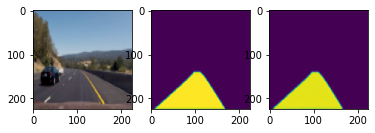

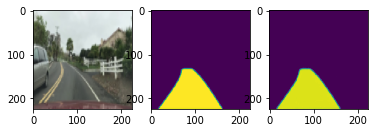

<Figure size 432x288 with 0 Axes>

In [10]:
in_channel = 3
out_channel = 1

batch_size = 8         # batch size
iterations = int(test_size / batch_size + 0.5)

model_path = base_path + "/UNet_50epochs_16batch_5e-3lr_0.995lrd.pt"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(in_channel, out_channel)
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))

# Move models to GPU if CUDA is available. 
model.to(device)

# Define the loss function. 
criterion = DiceLoss()

X, y = sample_dataset_minibatch(test_imgs, test_labels, batch_size)
tensor_X, tensor_y = torch.from_numpy(X).float().to(device), torch.from_numpy(y).long().to(device)
# print("X size: ", X.size())

outputs = model(tensor_X)

loss = criterion(outputs, tensor_y)
print("Loss: ", loss.item())
print()
print("%15s, %10s, %15s"%("Input Images", "Labels", "Model Outputs"))
# visualization
ori_imgs = np.transpose(X, (0,2,3,1))
ori_labels = np.squeeze(np.transpose(y, (0,2,3,1)))
model_outputs = np.squeeze(np.transpose(outputs.cpu().detach().numpy(), (0,2,3,1)))
for i in range(batch_size):
    plt.subplot(1,3,1)
    plt.imshow(ori_imgs[i])

    plt.subplot(1,3,2)
    plt.imshow(ori_labels[i])

    plt.subplot(1,3,3)
    plt.imshow(model_outputs[i])
        
    plt.figure()

plt.show()


3.2 Visualize the training loss and validation loss of training process

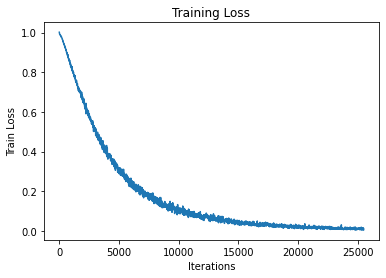

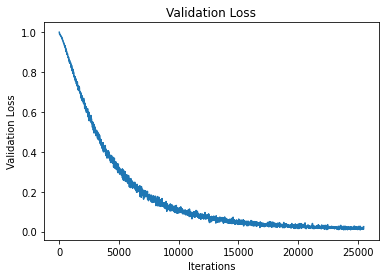

In [9]:
# Plot the training processes
import matplotlib.pyplot as plt

def plot(x, y, x_label, y_label, title):
    # plot x and y
    plt.plot(x, y)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()

iters = []
train_losses = []
val_losses = []
with open(base_path + 'training_outputs.txt', 'r') as f:
    for line in f.readlines():
        words = line.split()
        iters.append(int(words[1].split('/')[0][1:]))
        train_losses.append(float(words[4][:-1]))
        val_losses.append(float(words[-1]))

plot(iters, train_losses, "Iterations", "Train Loss", "Training Loss")
plot(iters, val_losses, "Iterations", "Validation Loss", "Validation Loss")

#4. Testing using real-life videos

4.1 Load video and visualize as plot

There are total 1107 frames in the video
Every frame's size is (1080, 1920, 3)
FPS of the video is 29.83



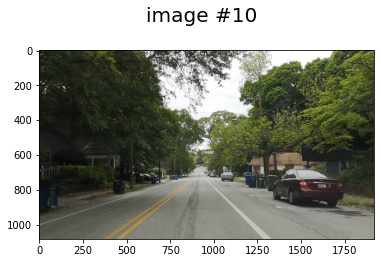

In [5]:
import pylab
import imageio

video1 = base_path + "Real_Life_Video_1.mp4"

video = imageio.get_reader(video1,  'ffmpeg')
total_frames = video.get_length()
frame_shape = video.get_data(0).shape
fps = video.get_meta_data()['fps']

print("There are total {} frames in the video".format(total_frames))
print("Every frame's size is {}".format(frame_shape))
print("FPS of the video is {}".format(fps))
print()
# visualize frames in the video
num_frame = 10
image = video.get_data(num_frame)
fig = pylab.figure()
fig.suptitle('image #{}'.format(num_frame), fontsize=20)
pylab.imshow(image)
pylab.show()

4.2 Resize every frames of video to model input size

100%|██████████| 1107/1107 [00:11<00:00, 99.21it/s] 


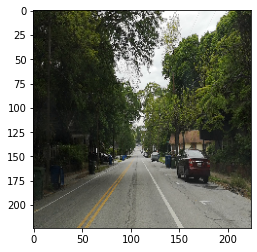

In [6]:
new_size = 224
data =  np.stack([np.asarray(Image.fromarray(current_data).resize((new_size, new_size), Image.NEAREST)) 
                        for current_data in tqdm(video)])
    

plt.imshow(data[10])

plt.show()

4.3 Feed every frame to the model

In [65]:
in_channel = 3
out_channel = 1

batch_size = 8 
iterations = int(total_frames / batch_size + 0.5)

model_path = base_path + "/UNet_50epochs_16batch_5e-3lr_0.995lrd.pt"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(in_channel, out_channel)
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))

# Move models to GPU if CUDA is available. 
model.to(device)

output_file = imageio.get_writer(base_path + "Real_Life_Video_1_output.mp4", fps=fps)

for i in range(iterations):
    labelled_imgs = []
    # Feed the images to the model and generate lanes
    if i == iterations - 1:
        X = data[i*batch_size:]
    else:
        X = data[i*batch_size:(i+1)*batch_size]
    X = np.transpose(X,(0,3,1,2))
    tensor_X = torch.from_numpy(X).float().to(device)

    outputs = model(tensor_X)

    ori_imgs = np.transpose(X, (0,2,3,1))
    model_outputs = np.squeeze(np.transpose(outputs.cpu().detach().numpy(), (0,2,3,1)))
    # visualization
    for i in range(batch_size):
        img = ori_imgs[i]
        output = model_outputs[i]

        plt.subplot(1,4,1)
        plt.imshow(img)

        plt.subplot(1,4,2)
        plt.imshow(output)

        plt.subplot(1,4,3)
        plt.imshow(img)
        plt.imshow(output, alpha=0.3)

        # Process the images to denoise
        output[:100,...] = 0
        kernel = kernel = np.ones((10,10), np.uint8) 
        erode = cv2.erode(output, kernel, iterations=1) 
        dilate_erode = cv2.dilate(erode, kernel, iterations=1)

        plt.subplot(1,4,4)
        plt.imshow(img)
        plt.imshow(dilate_erode, alpha=0.3)

        # Generate fake R & B color dimensions, stack with G
        lanes = np.expand_dims(dilate_erode, axis=2).astype(np.uint8)
        blanks = np.zeros_like(lanes).astype(np.uint8)
        lane_drawn = np.dstack((blanks, lanes, blanks))
        # combine original images and output from the model
        labelled_img = cv2.addWeighted(img, 1, lane_drawn, 1, 1)

        labelled_imgs.append(labelled_img)

        plt.figure()
    plt.show()

    # # Resize to video size
    # print(frame_shape[:2])
    # lane_drawn_frames =  np.stack([np.asarray(Image.fromarray(current_data).resize(frame_shape[:2], Image.NEAREST)) 
    #                         for current_data in tqdm(labelled_imgs)])
    
    # write to the video
    for frame in labelled_imgs:
        output_file.append_data(frame)
    
output_file.close()

Output hidden; open in https://colab.research.google.com to view.